#TODO - Add an oklahoma boundary polygon to the example, use that to filter out non-oklahoma events.

In [1]:
%matplotlib inline

In [2]:
#python standard library imports
import urllib
import sys
import json
from collections import OrderedDict
from datetime import datetime,timedelta
import os.path

#third party library imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

In [3]:
#constants
BASEURL = 'http://earthquake.usgs.gov/fdsnws/event/1/query?'

In this notebook we are going to use Python standard library modules (urllib, json, datetime, etc.) to download and do initial parsing of earthquake DYFI data found in ComCat, which is described here:

http://earthquake.usgs.gov/data/comcat/

and using the ComCat API, described here:

http://earthquake.usgs.gov/fdsnws/event/1/

Then we will use pandas, a library used for data analysis with time series and spreadsheet-like data structures, to extract all of the DYFI geocoded summary text files into one data structure. 


Let's make a sample query URL that should return one event (2011 M5.6 in Oklahoma), read it in, and see what we find.  For readability, we're not going to construct the query by hand, but use a Python dictionary instead and the *urllib.parse.urlencode()* method.

In [4]:
indict = {'format':'geojson',
         'starttime':datetime(2011,11,6,3,53,0),
         'endtime':datetime(2011,11,6,3,54,0),
         'minmag':5.5,
         'maxmag':5.7}
#the urllib module (in Python 3) encapsulates everything the standard library knows about urls
params = urllib.parse.urlencode(indict)
#assemble complete url
url = '%s%s' % (BASEURL,params)

#here we're using the request submodule to open a url, just like we would use open() to open a file.
f = urllib.request.urlopen(url)
#urlopen() returns a file-like object, which means that it behaves just like a file object does, including
#allowing you to read in all the data from the thing that has been opened.
#note the decode() method, which is a new necessity in Python 3, in order to convert a string of bytes
#into ASCII (utf-8).
data = f.read().decode('utf-8')
#Always close your file!
f.close()

In [5]:
print(data)

{"type":"FeatureCollection","metadata":{"generated":1479245424000,"url":"http://earthquake.usgs.gov/fdsnws/event/1/query?endtime=2011-11-06+03%3A54%3A00&format=geojson&starttime=2011-11-06+03%3A53%3A00&minmag=5.5&maxmag=5.7","title":"USGS Earthquakes","status":200,"api":"1.5.2","count":1},"features":[{"type":"Feature","properties":{"mag":5.7,"place":"Oklahoma","time":1320551590000,"updated":1473363133038,"tz":null,"url":"http://earthquake.usgs.gov/earthquakes/eventpage/usp000jadn","detail":"http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000jadn&format=geojson","felt":65328,"cdi":6.9,"mmi":null,"alert":null,"status":"reviewed","tsunami":0,"sig":1190,"net":"us","code":"p000jadn","ids":",usb0006klz,usp000jadn,atlas20111106035310,iscgem17507292,","sources":",us,us,atlas,iscgem,","types":",associate,dyfi,general-header,general-text,impact-text,moment-tensor,origin,phase-data,poster,shakemap,trump,","nst":474,"dmin":null,"rms":null,"gap":17.1,"magType":"mww","type":"earthquake","

Ack!  What's this?  As the format parameter suggests, it is *geojson*, which is specific version of json.

http://www.json.org/ - (JavaScript Object Notation) is a lightweight data-interchange format.

http://geojson.org/ - a format for encoding a variety of geographic data structures.

We can use a module called *json* (part of the Python standard library) to turn this long string of text into a useful data structure.


In [6]:
jsondict = json.loads(data)
jsondict

{'features': [{'geometry': {'coordinates': [-96.765, 35.532, 5.2],
    'type': 'Point'},
   'id': 'usp000jadn',
   'properties': {'alert': None,
    'cdi': 6.9,
    'code': 'p000jadn',
    'detail': 'http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000jadn&format=geojson',
    'dmin': None,
    'felt': 65328,
    'gap': 17.1,
    'ids': ',usb0006klz,usp000jadn,atlas20111106035310,iscgem17507292,',
    'mag': 5.7,
    'magType': 'mww',
    'mmi': None,
    'net': 'us',
    'nst': 474,
    'place': 'Oklahoma',
    'rms': None,
    'sig': 1190,
    'sources': ',us,us,atlas,iscgem,',
    'status': 'reviewed',
    'time': 1320551590000,
    'title': 'M 5.7 - Oklahoma',
    'tsunami': 0,
    'type': 'earthquake',
    'types': ',associate,dyfi,general-header,general-text,impact-text,moment-tensor,origin,phase-data,poster,shakemap,trump,',
    'tz': None,
    'updated': 1473363133038,
    'url': 'http://earthquake.usgs.gov/earthquakes/eventpage/usp000jadn'},
   'type': 'Feature'}],
 

This looks a *little* cleaner, but there's still a lot here.  We can see at least that jsondict is a dictionary, so let's investigate what the keys are:

In [7]:
print(jsondict.keys())
print()
for key,value in jsondict['metadata'].items():
    print('%s = %s' % (key,str(value)))
    
print()
print(jsondict['type'])

print()
print(type(jsondict['features']))
print(len(jsondict['features']))

dict_keys(['features', 'type', 'metadata'])

generated = 1479245424000
api = 1.5.2
title = USGS Earthquakes
count = 1
status = 200
url = http://earthquake.usgs.gov/fdsnws/event/1/query?endtime=2011-11-06+03%3A54%3A00&format=geojson&starttime=2011-11-06+03%3A53%3A00&minmag=5.5&maxmag=5.7

FeatureCollection

<class 'list'>
1


Features, it turns out, is the list of (one) event from our search.  Let's look at it and see what we have:

In [8]:
jsondict['features'][0]

{'geometry': {'coordinates': [-96.765, 35.532, 5.2], 'type': 'Point'},
 'id': 'usp000jadn',
 'properties': {'alert': None,
  'cdi': 6.9,
  'code': 'p000jadn',
  'detail': 'http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usp000jadn&format=geojson',
  'dmin': None,
  'felt': 65328,
  'gap': 17.1,
  'ids': ',usb0006klz,usp000jadn,atlas20111106035310,iscgem17507292,',
  'mag': 5.7,
  'magType': 'mww',
  'mmi': None,
  'net': 'us',
  'nst': 474,
  'place': 'Oklahoma',
  'rms': None,
  'sig': 1190,
  'sources': ',us,us,atlas,iscgem,',
  'status': 'reviewed',
  'time': 1320551590000,
  'title': 'M 5.7 - Oklahoma',
  'tsunami': 0,
  'type': 'earthquake',
  'types': ',associate,dyfi,general-header,general-text,impact-text,moment-tensor,origin,phase-data,poster,shakemap,trump,',
  'tz': None,
  'updated': 1473363133038,
  'url': 'http://earthquake.usgs.gov/earthquakes/eventpage/usp000jadn'},
 'type': 'Feature'}

So, a "feature" is a dictionary giving summary information about an event: 

 * coordinates - a sub-dictionary, which contains a list of [lon,lat,depth]
 * id - Earthquake ID
 * properties - A dictionary of summary properties, including magnitude and origin time (number of milliseconds since Unix epoch) 
 
 One of those properties is "detail" which is the url from which you can get *all* of the contents of an event.  Let's look at that using some of the same techniques as before.

In [9]:
durl = jsondict['features'][0]['properties']['detail']
fh = urllib.request.urlopen(durl)
data = fh.read().decode('utf-8')
fh.close()
ejsondict = json.loads(data)
ejsondict

{'geometry': {'coordinates': [-96.765, 35.532, 5.2], 'type': 'Point'},
 'id': 'usp000jadn',
 'properties': {'alert': None,
  'cdi': 6.9,
  'code': 'p000jadn',
  'dmin': None,
  'felt': 65328,
  'gap': 17.1,
  'ids': ',usb0006klz,usp000jadn,atlas20111106035310,iscgem17507292,',
  'mag': 5.7,
  'magType': 'mww',
  'mmi': None,
  'net': 'us',
  'nst': 474,
  'place': 'Oklahoma',
  'products': {'associate': [{'code': 'usb0006klz_usp000jadn',
     'contents': [],
     'id': 'urn:usgs-product:us:associate:usb0006klz_usp000jadn:1424389332749',
     'indexTime': 1424389338934,
     'indexid': '49998301',
     'preferredWeight': 6,
     'properties': {'eventsource': 'us',
      'eventsourcecode': 'b0006klz',
      'othereventsource': 'us',
      'othereventsourcecode': 'p000jadn'},
     'source': 'us',
     'status': 'UPDATE',
     'type': 'associate',
     'updateTime': 1424389332749}],
   'dyfi': [{'code': 'usp000jadn',
     'contents': {'cdi_geo.txt': {'contentType': 'text/plain',
       'la

So this is also geojson, and it has the same top-level structure as the feature from the previous url.  If you look at the "properties" dictionary, however, you will notice that it has a "products" field.  This points to a dictionary containing all of the information known about each of the products (origins, moment-tensors, shakemaps, etc.), including links to any of the data files that you can find in the "Downloads" list for each of those products.

Our example will include the use of the Did You Feel It (DYFI) geocoded Intensity Summary text file, which is in this event (but not all).  Here it is:

http://earthquake.usgs.gov/archive/product/dyfi/usb0006klz/us/1459231914543/cdi_geo.txt

The columns are listed at the top, although the last column appears to not be documented and also be a duplicate of the first column.  We're going to use a package called *pandas* to read this data into a spreadsheet-like structure called a *DataFrame*.

In [10]:
cdi_url = ejsondict['properties']['products']['dyfi'][0]['contents']['cdi_geo.txt']['url']
columns = ['Box','CDI','NumResponses','HypoDistance',
            'Latitude','Longitude','Suspect?','City','State','box2']
table = pd.read_table(cdi_url,sep=',',skiprows=[0],names=columns)
table.head()

,Box,CDI,NumResponses,HypoDistance,Latitude,Longitude,Suspect?,City,State,box2
0,UTM:(13R 074 352 10000),2.0,1,665,31.8344,-102.4111,0,Odessa,NaN,NaN
1,UTM:(13S 041 394 10000),2.7,1,831,35.6452,-105.9389,0,Gardner,NaN,NaN
2,UTM:(13S 045 436 10000),2.0,1,887,39.4334,-105.5229,0,Holts Summit,NaN,NaN
3,UTM:(13S 045 437 10000),3.8,3,892,39.5234,-105.5236,0,Wichita,NaN,NaN
4,UTM:(13S 048 439 10000),3.7,8,875,39.7047,-105.1749,0,Oklahoma City,NaN,NaN


Let's define a simple function to take in a dictionary with search parameters (see http://earthquake.usgs.gov/fdsnws/event/1/).  The format will be hard-coded to 'geojson', and Python *datetime* objects will be converted to the appropriate date/time string format.

In [11]:
def getRequestData(indict):
    """Return the list of earthquake features from a ComCat API search.
    
    This function does no error handling - use at your own risk.
    
    :param indict:
      Dictionary containing any of the parameters described in http://earthquake.usgs.gov/fdsnws/event/1/.
    :returns: 
      List of earthquake features.
    """
    #we are hardcoding format to geojson
    indict['format'] = 'geojson'
    #we want earthquakes to be sorted ascending by time
    indict['orderby'] = 'time-asc'
    copydict = indict.copy()
    for key,value in copydict.items():
        #re-format datetime objects to ISO string representations
        if isinstance(value,datetime):
            copydict[key] = value.strftime('%Y-%m-%dT%H:%M:%S')
            
    #assemble dictionary into url parameters string
    params = urllib.parse.urlencode(indict)
    #assemble complete url
    url = '%s%s' % (BASEURL,params)
    #open a file-like object on the url
    f = urllib.request.urlopen(url)
    #read the data from that file-like object, remembering to decode the bytes into an ASCII JSON string.
    data = f.read().decode('utf-8')
    #parse that JSON string into a data structure (list of dictionaries). 
    features = json.loads(data)['features']
    f.close()
    return features

The function above returns a list of earthquake dictionaries.  Let's get a handle on what is in those dictionaries, and in particular choose one that has the data we're interested in (summary geocoded intensities).

In [12]:
END = datetime.utcnow()
START = END - timedelta(days=90) #three months back
params = {'starttime':datetime(2016,2,13,17,7,0),
          'endtime':datetime.utcnow(),
          'minmagnitude':4.5,
          'maxmagnitude':9.9,
          'minlatitude':33.49,
          'maxlatitude':37.234,
          'minlongitude':-103.118,
          'maxlongitude':-94.219,
          'producttype':'dyfi',
         }
events = getRequestData(params)
print(len(events))

4


Let's examine the structure of one of the events we have downloaded.

In [13]:
event = events[0] #events is a list, this gets the first (zeroth) element in the list
print('Event is an instance of %s' % type(event))

Event is an instance of <class 'dict'>


So now we know that an event is indeed a dictionary, which is easy to inspect.

In [14]:
print('The keys of the event dictionary are: %s' % list(event.keys()))

The keys of the event dictionary are: ['id', 'properties', 'geometry', 'type']


Let's look at the 'id', 'geometry', and 'type' fields, leaving 'properties' aside for the moment.

In [15]:
print(event['id'])
print(event['type'])
print(event['geometry'])

us20004zy8
Feature
{'type': 'Point', 'coordinates': [-98.709, 36.4898, 8.31]}


Ok, so event ID, "Feature", and what looks like the longitude, latitude, and depth of the event, inside another dictionary called "coordinates".

'properties' sounds promising - let's look at that (it's a dictionary). Use the *items()* method of the dictionary object to iterate over the key/value pairs.

In [16]:
print('The keys of the event properties dictionary are: \n')
for key,value in event['properties'].items():
    print('%s = %s' % (key,str(value)))

The keys of the event properties dictionary are: 

place = 31km NW of Fairview, Oklahoma
code = 20004zy8
title = M 5.1 - 31km NW of Fairview, Oklahoma
type = earthquake
tz = -360
sources = ,us,gcmt,
nst = None
net = us
gap = 17
cdi = 6.8
detail = http://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us20004zy8&format=geojson
types = ,cap,dyfi,general-link,geoserve,impact-text,losspager,moment-tensor,nearby-cities,origin,phase-data,shakemap,tectonic-summary,
status = reviewed
mmi = 5.61
mag = 5.1
rms = 1.09
time = 1455383226290
tsunami = 0
dmin = 0.218
alert = green
sig = 1080
ids = ,us20004zy8,gcmt20160213170706,
magType = mww
updated = 1478815937393
url = http://earthquake.usgs.gov/earthquakes/eventpage/us20004zy8
felt = 4043


What fields here are interesting for our purposes?  For our later analysis of the DYFI intensities, we're interested in the "time" and "mag" fields. There is also a string "detail" that has the geojson url for the event, which we will need to get at all of the event specific information.  Let's make a function that peeks into the detailed information for the event and extracts the "cdi_geo.txt" file into a pandas DataFrame.

In [17]:
#TODO - write a section exploring the event detail geojson...

In [18]:
def getDYFITable(event):
    """Retrieve a geo-coded DYFI summary file from the event dictionary obtained by getRequestData().
    
    :param event:
      Event dictionary containing fields:
        - id Event ID.
        - geometry Dictionary containing 'coordinates' field with 3-element list of [lon,lat,depth].
        - properties Dictionary containing fields:
          - time Number of milliseconds since Jan 1 1970 (Unix epoch).
          - mag  Magnitude.
          - detail url of event-specific geojson.
    :returns:
      pandas DataFrame containing the contents of the DYFI geocoded Intensity Summary text file, 
      OR
      None, as these files are not compiled for all events with DYFI results.
    """
    #extract all of the event-specific parameters
    eventid = event['id']
    lon,lat,depth = event['geometry']['coordinates']
    time = datetime.utcfromtimestamp(event['properties']['time']//1000)
    mag = event['properties']['mag']
    
    #next open the url for the event-specific page, read it's JSON data, parse into event dictionary. 
    detail = event['properties']['detail']
    fh = urllib.request.urlopen(detail)
    eventdata = fh.read().decode('utf-8')
    fh.close()
    eventjson = json.loads(eventdata)
    
    #make sure dyfi is listed as one of the products
    if 'dyfi' not in eventjson['properties']['products']:
        return None
    
    #make sure the geocoded intensity summary file is included among list of DYFI output.
    dyfistuff = eventjson['properties']['products']['dyfi'][0]['contents']
    if 'cdi_geo.txt' not in dyfistuff:
        return None
    
    #get the url for the intensity summary file
    cdifile = dyfistuff['cdi_geo.txt']['url']
    #read in the text file using the pandas read_table() function, specifying the names of the columns
    columns = ['Box','CDI','NumResponses','HypoDistance',
               'Latitude','Longitude','Suspect?','City','State','box2']
    table = pd.read_table(cdifile,sep=',',skiprows=[0],names=columns)
    
    #box2 appears to be a duplicate of the first column.  Let's drop it.
    table.drop('box2', axis=1, inplace=True)
    
    #Now let's add in the eventid, time, lat,lon,depth,mag columns.
    #These will be duplicated for each row, which is an inefficiency we'll live with
    #for the sake of ease of use.
    nrows = len(table)
    table['EventID'] = [eventid]*nrows
    table['Time'] = [time]*nrows
    table['EventLatitude'] = [lat]*nrows
    table['EventLongitude'] = [lon]*nrows
    table['EventDepth'] = [depth]*nrows
    table['Magnitude'] = [mag]*nrows
    
    #re-order the columns the way we want them
    cols = ['Box','EventID','Time','EventLatitude','EventLongitude','EventDepth',
            'Magnitude','CDI','NumResponses','HypoDistance','Latitude','Longitude',
            'Suspect?','City','State']
    table = table[cols]
    return table

Let's extract one table for an event that we know has the geo-coded summary text file, and take a look at the first five rows.

In [19]:
table = getDYFITable(event)
table.head()

,Box,EventID,Time,EventLatitude,EventLongitude,EventDepth,Magnitude,CDI,NumResponses,HypoDistance,Latitude,Longitude,Suspect?,City,State
0,UTM:(14R 061 333 10000),us20004zy8,2016-02-13 17:07:06,36.4898,-98.709,8.31,5.1,1.0,1,709,30.1409,-97.8059,0,Austin,NaN
1,UTM:(14S 023 372 10000),us20004zy8,2016-02-13 17:07:06,36.4898,-98.709,8.31,5.1,3.1,1,427,33.6319,-101.8569,0,Lubbock,NaN
2,UTM:(14S 028 391 10000),us20004zy8,2016-02-13 17:07:06,36.4898,-98.709,8.31,5.1,2.0,1,270,35.3551,-101.3662,0,Panhandle,NaN
3,UTM:(14S 028 395 10000),us20004zy8,2016-02-13 17:07:06,36.4898,-98.709,8.31,5.1,2.0,1,255,35.7155,-101.3768,0,Borger,NaN
4,UTM:(14S 028 406 10000),us20004zy8,2016-02-13 17:07:06,36.4898,-98.709,8.31,5.1,2.2,1,242,36.7064,-101.4069,0,Guymon,NaN


Our goal is to accumulate all of the summary geo-coded intensity data for as many events as we can into *one* DataFrame.  To help us keep track of which event is which, and to allow us to do some analysis on similar events, we've added event ID, time, event lat, event lon, event depth, and magnitude columns.  They'll be duplicated several times (*non-normalized* in relational database parlance), but we can live with that for the sake of simplicity. 

Now that we know what we're getting, let's search from the beginning of 2016 to July 18, 2016, looking for M1.5+ events containing DYFI results in Oklahoma, returning the event information into a list called *events*, then printing out the number of events we have found.

In [20]:
params = {'starttime':datetime(2016,1,1),
          'endtime':datetime(2016,7,19),
          'minmagnitude':3.5,
          'maxmagnitude':9.9,
          'minlatitude':33.49,
          'maxlatitude':37.234,
          'minlongitude':-103.118,
          'maxlongitude':-94.219,
          'producttype':'dyfi',
         }
events = getRequestData(params)
print('%i events found between %s and %s' % (len(events),params['starttime'],params['endtime']))

86 events found between 2016-01-01 00:00:00 and 2016-07-19 00:00:00


In [21]:
t1 = datetime.now()
df = None
nevents = 0
months = []
for event in events:
    etime = datetime.utcfromtimestamp(event['properties']['time']//1000)
    monstr = etime.strftime('%Y-%m')
    if monstr not in months:
        sys.stdout.write(monstr)
        months.append(monstr)
    table = getDYFITable(event)
    if table is None:
        continue
    nevents += 1
    if df is None:
        sys.stdout.write('.')
        #print('Appending %i rows to DataFrame' % len(table))
        df = table.copy()
    else:
        sys.stdout.write('.')
        #print('Appending %i rows to DataFrame' % len(table))
        df = df.append(table.copy(),ignore_index=True)

print()
t2 = datetime.now()
nsecs = (t2-t1).seconds
print('DataFrame has %i rows from %i events - %i seconds elapsed.' % (len(df),nevents,nsecs))

2016-01...........................2016-02.............2016-03......2016-04....2016-05.2016-062016-07......
DataFrame has 3023 rows from 57 events - 29 seconds elapsed.


Now we have a pandas DataFrame object consisting of the rows and columns of the "stationlist.txt" file from the event with the most rows (station data) of all events in our search.  Here we print out the first 5 rows with clean looking HTML.

In [22]:
outfile = os.path.join(os.path.expanduser('~'),'dyfi_oklahoma.csv')
df.to_csv(outfile)
1769/60

29.483333333333334

In [23]:
df.head()

,Box,EventID,Time,EventLatitude,EventLongitude,EventDepth,Magnitude,CDI,NumResponses,HypoDistance,Latitude,Longitude,Suspect?,City,State
0,UTM:(14S 057 391 10000),us10004aqg,2016-01-01 11:39:39,35.6688,-97.4065,5.825,4.2,2.0,1,77,35.3755,-98.1743,0,Binger,NaN
1,UTM:(14S 061 389 10000),us10004aqg,2016-01-01 11:39:39,35.6688,-97.4065,5.825,4.2,3.1,1,61,35.1914,-97.7368,0,Tuttle,NaN
2,UTM:(14S 061 390 10000),us10004aqg,2016-01-01 11:39:39,35.6688,-97.4065,5.825,4.2,2.5,3,52,35.2815,-97.7354,0,Tuttle,NaN
3,UTM:(14S 061 391 10000),us10004aqg,2016-01-01 11:39:39,35.6688,-97.4065,5.825,4.2,2.8,3,44,35.3717,-97.7340,0,Mustang,NaN
4,UTM:(14S 061 392 10000),us10004aqg,2016-01-01 11:39:39,35.6688,-97.4065,5.825,4.2,3.0,10,37,35.4618,-97.7326,0,Mustang,NaN


If one were to develop an Intensity Prediction Equation (IPE), the next step might be to plot intensity vs log distance for groupings of magnitudes.  Let's figure out how many magnitudes we have...

In [24]:
df2 = df[df.NumResponses >= 3]

In [25]:
len(df2)

634

In [26]:
umags = np.unique(df2.Magnitude)
print('%i unique magnitudes between %.1f and %.1f' % (len(umags),umags.min(),umags.max()))
print('%s' % (str(umags)))

9 unique magnitudes between 3.5 and 5.1
[ 3.5  3.6  3.7  3.8  3.9  4.2  4.4  4.7  5.1]


In [27]:
def floor_to_nearest(value,floor_value=1000):
    """Return the value, floored to nearest floor_value (defaults to 1000).
    
    :param value: 
      Value to be floored.
    :param floor_value: 
      Number to which the value should be floored.
    :returns:
      Floored value.
    """
    if floor_value < 1:
        ds = str(floor_value)
        nd = len(ds) - (ds.find('.')+1)
        value = value * 10**nd
        floor_value = floor_value * 10**nd
        value = int(np.floor(float(value)/floor_value)*floor_value)
        value = float(value) / 10**nd
    else:
        value = int(np.floor(float(value)/floor_value)*floor_value)
    return value

In [28]:
def ceil_to_nearest(value,ceil_value=1000):
    """Return the value, ceiled to nearest ceil_value (defaults to 1000).
    
    :param value: 
      Value to be ceiled.
    :param ceil_value: 
      Number to which the value should be ceiled.
    :returns:
      Ceiled value.
    """
    if ceil_value < 1:
        ds = str(ceil_value)
        nd = len(ds) - (ds.find('.')+1)
        value = value * 10**nd
        ceil_value = ceil_value * 10**nd
        value = int(np.ceil(float(value)/ceil_value)*ceil_value)
        value = float(value) / 10**nd
    else:
        value = int(np.ceil(float(value)/ceil_value)*ceil_value)
    return value

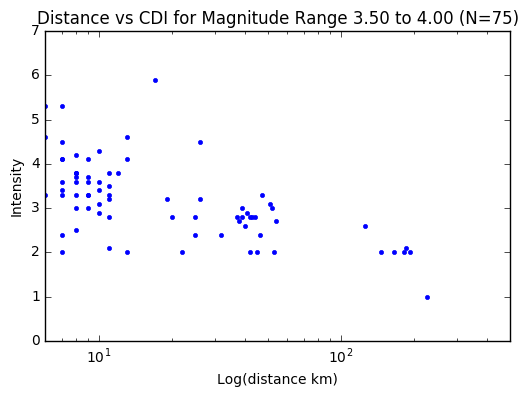

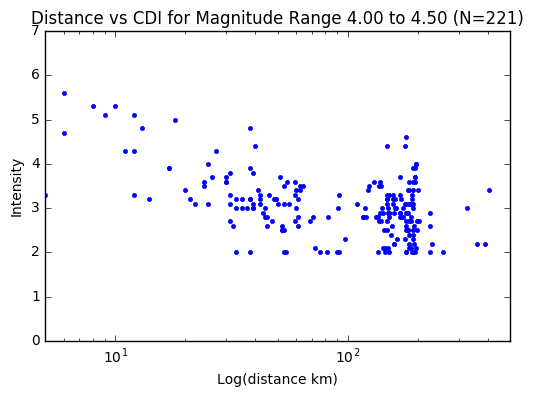

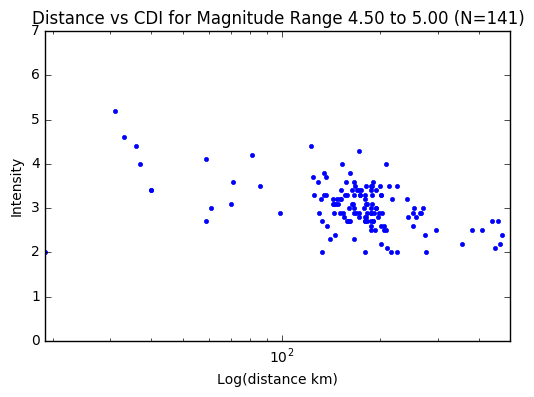

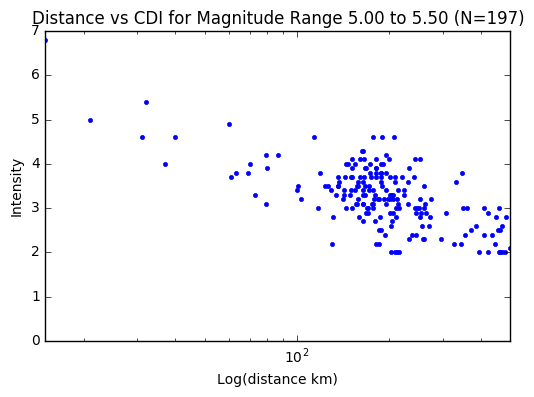

In [29]:
magmin = floor_to_nearest(umags.min(),0.5)
magmax = ceil_to_nearest(umags.max(),0.5)
for maglow in np.arange(magmin,magmax,0.5):
    maghigh = maglow + 0.5
    df_sub = df2[(df2.Magnitude >= maglow) & (df2.Magnitude < maghigh)]
    f = plt.figure();
    plt.semilogx(df_sub.HypoDistance,df_sub.CDI,'b.');
    plt.axis([0,500,0,7])
    plt.title('Distance vs CDI for Magnitude Range %.2f to %.2f (N=%i)' % (maglow,maghigh,len(df_sub)));
    plt.xlabel('Log(distance km)');
    plt.ylabel('Intensity');

In [30]:
np.arange(magmin,magmax+0.25,0.25)
#magmin,magmax

array([ 3.5 ,  3.75,  4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ])

We can now plot the station points on a map, with some graticules and a coastline using the *Basemap* module.

http://matplotlib.org/basemap/index.html

In [31]:
ymin,ymax = (table.latitude.min(),table.latitude.max())
xmin,xmax = (table.longitude.min(),table.longitude.max())
cx,cy = (np.mean([ymin,ymax]),np.mean([xmin,xmax]))
aspect = (ymax-ymin)/(xmax-xmin)
figwidth = 12
figheight = aspect * figwidth
f = plt.figure(figsize=(figwidth,figheight))
ax = f.add_axes([0.1,0.1,0.8,0.8])
m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,projection='mill',resolution='h')
m.drawcoastlines();
par = np.arange(np.ceil(ymin),np.floor(ymax)+1,1.0)
mer = np.arange(np.ceil(xmin),np.floor(xmax)+1,1.0)
merdict = m.drawmeridians(mer,labels=[0,0,0,1],fontsize=10,
                          linewidth=0.5,color='gray')
pardict = m.drawparallels(par,labels=[1,0,0,0],fontsize=10,
                          linewidth=0.5,color='gray')
lats = table.latitude.values
lons = table.longitude.values
m.plot(lons,lats,'b^',latlon=True);
plt.title('Station locations for event %s' % maxid);

AttributeError: 'DataFrame' object has no attribute 'latitude'

#TODO
<font color="red" size="20">What else is interesting to do with station data?</font>

In [ ]:
url = 'http://earthquake.usgs.gov/realtime/product/dyfi/us20006fas/us/1468890673733/cdi_geo.txt'
columns = ['Box','CDI','NumResponses','HypoDistance',
            'Latitude','Longitude','Suspect?','City','State','box2']
table = pd.read_table(url,sep=',',skiprows=[0],names=columns)


In [ ]:
table2 = table[table.NumResponses >= 3]
plt.semilogx(table2.HypoDistance,table2.CDI,'b.')

In [ ]:
df[df.CDI < 0]